# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import sys
sys.path.append("/home/kevinhardin/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/games:/usr/games")
sys.path.append("CameraScript")
sys.path.append("/home/kevinhardin/Documents/GEORGE")
# sys.path.append("/Users/kevinhardin/Documents/GitHub/GEORGE")
# from CameraScript import takePic
from time import sleep, time
from datetime import datetime, date
import os
os.environ["LIBCAMERA_LOG_LEVELS"] = "2"
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import glob
import numpy as np
import tensorflow as tf
from pathlib import Path
from GEORGE_Library import *
%matplotlib inline

print("Done")

2025-08-24 16:56:48.886464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done


## Define global variables

In [2]:
label_id_offset = 1
score_threshold = 0.4
category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
model_directory = "/home/kevinhardin/Documents/GEORGE"
# model_directory = "/Users/kevinhardin/Documents/GitHub/GEORGE"
model_name = 'extract_superimp_model'
model_dest = os.path.join(os.sep, model_directory, model_name)

print("Done")

Done


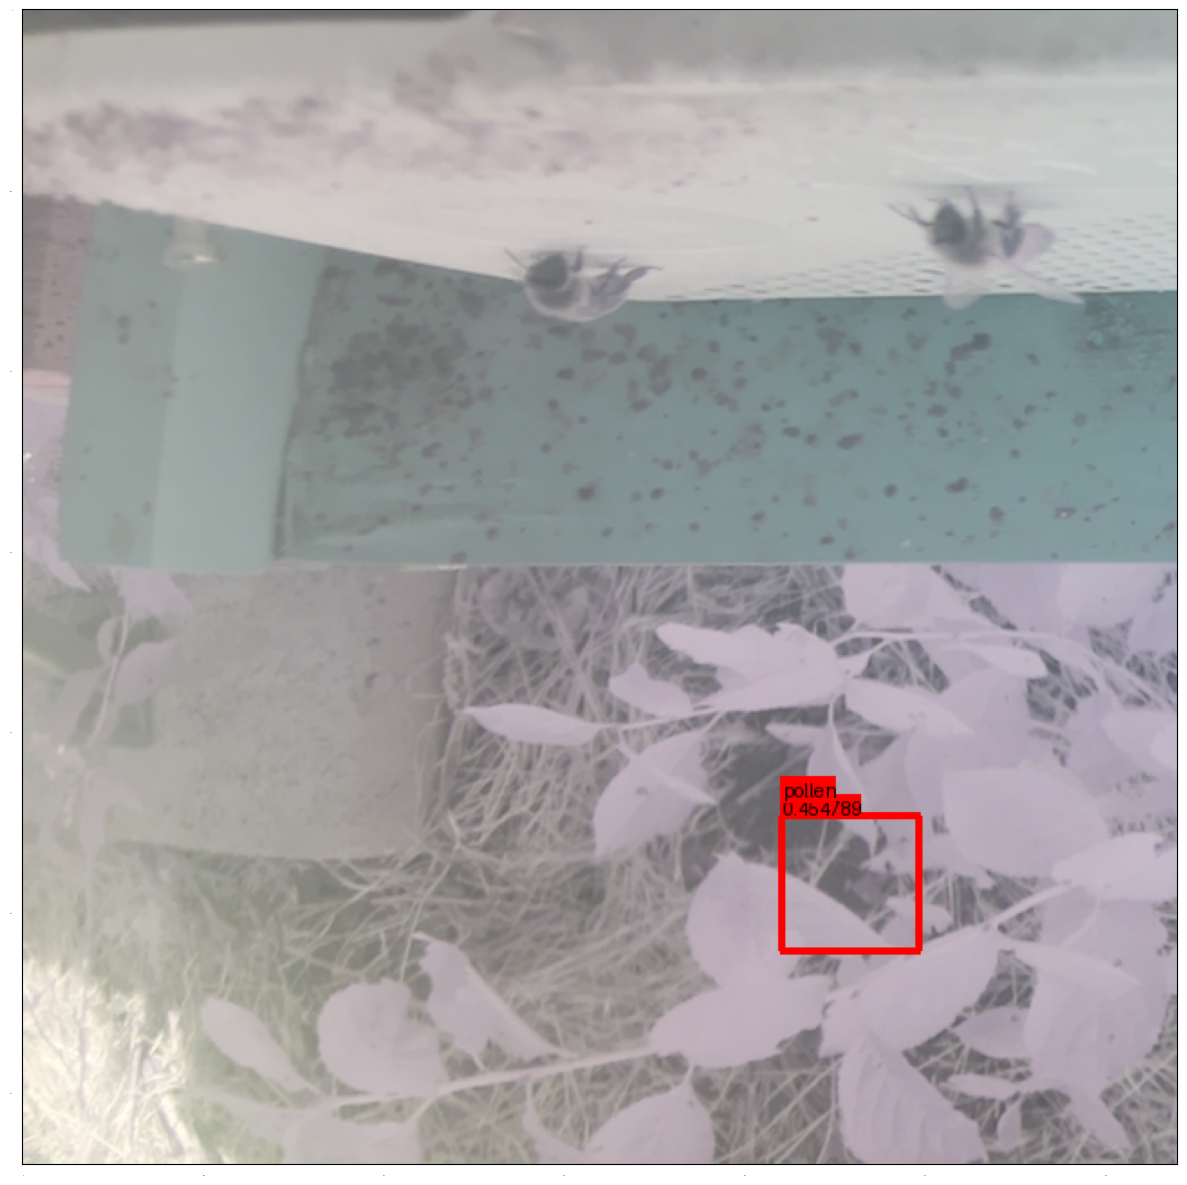

No detections
No detections


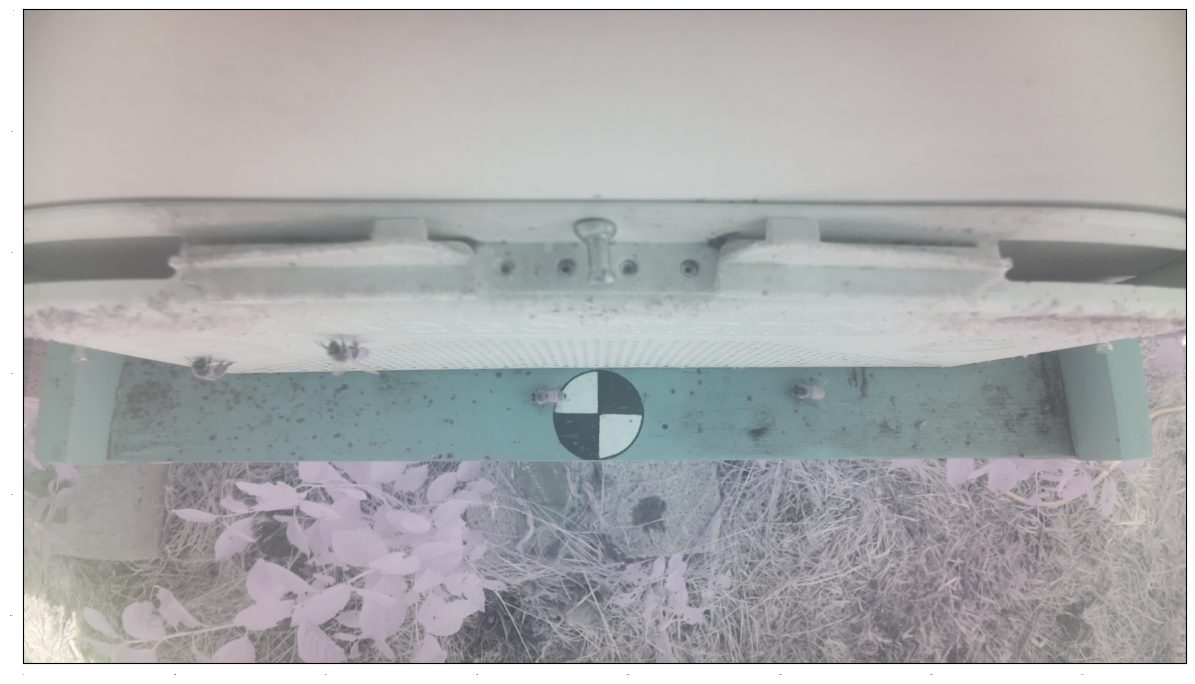

In [3]:
new_model = tf.saved_model.load(model_dest)

while True:
    current_datetime = datetime.now()
    current_hour = int(current_datetime.strftime("%H"))
    if 8 <= current_hour <= 18:
        for item in os.listdir("tmp"):
            item_path = os.path.join("tmp", item)
            if os.path.isfile(item_path):
                os.remove(item_path)
                
        current_filename = "tmp/image" + current_datetime.strftime("_%y-%m-%d_%H_%M_%S") + ".png"
        im, _, _ = takePic()
        im.save(current_filename)

        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
        plt.rcParams['figure.figsize'] = [15, 15]
        
        save_plot = False
        csv_data_file_path = "GEORGE_data.csv"
        if glob.glob(csv_data_file_path) == []:
            print("Creating new CSV data file")
            df = pd.DataFrame(columns=['datetime','category','score'])
            df.to_csv(csv_data_file_path, index = False)
        
        im = Image.open(current_filename)
        
        for i in range(3):
            image = np.array(im).astype('uint8')[440:, (640 * i):(640 * (i + 1)), :]
        
            bboxes = []
            class_ids = []
            scores = []
        
            input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
            input_tensor = tf.expand_dims(input_tensor, 0)
            detections = new_model.signatures['detect'](input_tensor)
        
            for k in range(len(detections['detection_boxes'][0])):
                if detections['detection_scores'][0][k].numpy() >= score_threshold:
                    y1, x1, y2, x2  = np.array(detections['detection_boxes'][0][k])
                    bboxes.append([y1, x1, y2, x2])
                    class_id = detections['detection_classes'][0][k].numpy().astype(np.uint32) + label_id_offset
                    class_name = category_index[class_id]['name']
                    score = detections['detection_scores'][0][k].numpy()
                    class_ids.append(class_id)
                    scores.append(score)
        
            if not scores == []:        
                for category, score in zip([category_index[class_id]["name"] for class_id in np.asarray(class_ids)], scores):
                    data_new = {'datetime': current_datetime.strftime("%y-%m-%d_%H_%M_%S"), 'category': category, 'score': score}
                    df_new = pd.DataFrame([data_new])
                
                    # Append the new data to the existing CSV
                    df_new.to_csv(csv_data_file_path, mode='a', header=False, index=False)
                
                fig, ax = plt.subplots()
                new_image = Image.fromarray(image)
                draw_bounding_boxes_on_image(new_image, np.asarray(bboxes), display_str_list_list = list(zip([category_index[class_id]["name"] for class_id in np.asarray(class_ids)], [str(i) for i in scores])))
                plt.imshow(new_image)
                plt.show()
        
            else:
                print("No detections")
        
        fig, ax = plt.subplots()
        plt.imshow(im)
        plt.show()